# 导入部分

In [1]:
# 导入数据操作和数学运算需要的库
import pandas as pd
import numpy as np
from math import sqrt

import os
import joblib

# 导入机器学习模型和评估指标
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc, classification_report
from sklearn.linear_model import LogisticRegression

# 导入模型训练和评估工具
from sklearn.model_selection import train_test_split

# 导入可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 导入XGBoost，一个高效的机器学习算法
import xgboost as xgb

# 设置警告过滤器以忽略不必要的警告
import warnings
warnings.filterwarnings('ignore')

# 配置matplotlib以支持中文字符，并进行美观调整
plt.rcParams['font.sans-serif'] = ['simhei']  # 设置sans-serif字体为simhei
plt.rcParams['font.serif'] = ['simhei']       # 设置serif字体为simhei
plt.rcParams['axes.unicode_minus'] = False    # 确保负号显示正常

# 配置seaborn以保持一致的美学风格和字体支持
sns.set_style("darkgrid", {"font.sans-serif": ['simhei', 'Droid Sans Fallback']})

In [2]:
data = pd.read_csv('./Datasets/附件1/M101.csv')
data.head(10)

,日期,时间,生产线编号,物料推送气缸推送状态,物料推送气缸收回状态,物料推送数,物料待抓取数,放置容器数,容器上传检测数,填装检测数,...,不合格数,物料推送装置故障1001,物料检测装置故障2001,填装装置检测故障4001,填装装置定位故障4002,填装装置填装故障4003,加盖装置定位故障5001,加盖装置加盖故障5002,拧盖装置定位故障6001,拧盖装置拧盖故障6002
0,1,0,M101,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,M101,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,M101,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,M101,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,M101,0,1,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,5,M101,1,0,3,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,6,M101,0,1,3,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,7,M101,0,1,3,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,8,M101,0,1,3,3,2,1,0,...,0,0,0,0,0,0,0,0,0,0
9,1,9,M101,0,1,3,3,2,1,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# TODO 日期，生产线编号 被去掉了
X = data[[ '时间', '物料推送气缸推送状态', '物料推送气缸收回状态', '物料推送数', '物料待抓取数',
       '放置容器数', '容器上传检测数', '填装检测数', '填装定位器固定状态', '填装定位器放开状态', '物料抓取数', '填装旋转数',
       '填装下降数', '填装数', '加盖检测数', '加盖定位数', '推盖数', '加盖下降数', '加盖数', '拧盖检测数',
       '拧盖定位数', '拧盖下降数', '拧盖旋转数', '拧盖数', '合格数', '不合格数']]

In [4]:
# 把故障处理为 0 和 1
data['加盖装置加盖故障5002'] = data['加盖装置加盖故障5002'].apply(lambda x : 0 if x == 0 else 1 )
Y = data['加盖装置加盖故障5002']

In [5]:
data['加盖装置加盖故障5002'].value_counts()

加盖装置加盖故障5002
0    634300
1      2209
Name: count, dtype: int64

In [6]:
data['加盖装置加盖故障5002'].value_counts()

加盖装置加盖故障5002
0    634300
1      2209
Name: count, dtype: int64

# 不平衡数据可视化

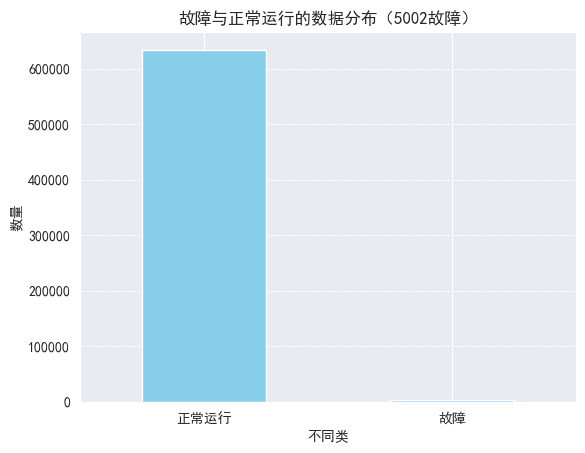

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设Y是一个包含类别数据的Pandas Series
class_counts = pd.value_counts(Y, sort=True).sort_index()

# 创建条形图
class_counts.plot(kind='bar', rot=0, color='skyblue')

# 添加图表的标题和轴标签
plt.title('故障与正常运行的数据分布（5002故障）')
plt.xlabel('不同类')
plt.ylabel('数量')

# 设置x轴的刻度标签
classes = ['正常运行', '故障']
plt.xticks(range(len(classes)), classes)

# 显示网格线以便更容易读取具体数值
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# 显示图表
plt.show()

# 封装模型部分

In [8]:
def train_evaluate_save_model(model, model_name, X_train, Y_train, X_test, Y_test, axs, plot_row, plot_col, save_path, ways):
    # 训练模型并评估其性能
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print(f'{model_name} 模型评价结果：')
    print("ACC", accuracy_score(Y_test, y_pred))
    print("REC", recall_score(Y_test, y_pred))
    print("F-score", f1_score(Y_test, y_pred))
    print(classification_report(Y_test, y_pred))

    # 计算并绘制ROC曲线
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    axs[plot_row][plot_col].plot(fpr, tpr, color='darkorange', lw=2)
    axs[plot_row][plot_col].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[plot_row][plot_col].set_xlim([0.0, 1.0])
    axs[plot_row][plot_col].set_ylim([0.0, 1.05])
    axs[plot_row][plot_col].set_xlabel('假阳性率')
    axs[plot_row][plot_col].set_ylabel('真阳性率')
    axs[plot_row][plot_col].set_title(f'{model_name} ROC (AUC = {roc_auc:.2f})')

    # 保存模型
    # model_path = os.path.join(save_path, model_name)
    model_path = save_path
    os.makedirs(model_path, exist_ok=True)
    joblib.dump(model, os.path.join(model_path, f'{model_name}_{ways}.joblib'))

# 不同模型汇总

## 原数据

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

# 定义模型和配置
models = {
    '逻辑回归': LogisticRegression(),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    '决策树': DecisionTreeClassifier(random_state=42),
    '随机森林': RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
}

# 创建绘图区域
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 训练、评估、绘图并保存每个模型
for i, (name, model) in enumerate(models.items()):
    train_evaluate_save_model(model, name, X_train, Y_train, X_test, Y_test, axs, i // 3, i % 3, './Models/5002/', '原数据')
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('./Images/%sROC_原始数据.png'%'加盖装置加盖故障5002')

## SMOTE过采样

In [ ]:
from imblearn.over_sampling import SMOTE
X_resampled_SMOTE, y_resampled_SMOTE = SMOTE().fit_resample(X, Y)

In [ ]:
from collections import Counter
Counter(y_resampled_SMOTE)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled_SMOTE, y_resampled_SMOTE, test_size=0.25)

# 定义模型和配置
models = {
    '逻辑回归': LogisticRegression(),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    '决策树': DecisionTreeClassifier(random_state=42),
    '随机森林': RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
}

# 创建绘图区域
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 训练、评估、绘图并保存每个模型
for i, (name, model) in enumerate(models.items()):
    train_evaluate_save_model(model, name, X_train, Y_train, X_test, Y_test, axs, i // 3, i % 3, './Models/5002/', '过采样')
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('./Images/%sROC_smote.png'%'加盖装置加盖故障5002')

## 随机欠采样

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
X_resampled_RandomUnderSampler, y_resampled_RandomUnderSampler = RandomUnderSampler(random_state=42).fit_resample(X, Y)#

In [ ]:
Counter(y_resampled_RandomUnderSampler)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled_RandomUnderSampler, y_resampled_RandomUnderSampler, test_size=0.25)
# 定义模型和配置
models = {
    '逻辑回归': LogisticRegression(),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    '决策树': DecisionTreeClassifier(random_state=42),
    '随机森林': RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
}

# 创建绘图区域
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 训练、评估、绘图并保存每个模型
for i, (name, model) in enumerate(models.items()):
    train_evaluate_save_model(model, name, X_train, Y_train, X_test, Y_test, axs, i // 3, i % 3, './Models/5002/', '欠采样')
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('./Images/%sROC_随机欠采样.png'%'加盖装置加盖故障5002')